In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from PIL import Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import scipy.ndimage
import scipy.misc
%matplotlib inline

In [3]:
dataset_location = 'datasets/svhn_raw/'

In [4]:
import h5py

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [4]:
fin = os.path.join(dataset_location + 'test', 'digitStruct.mat')
dsf = DigitStructFile(fin)
test_data = dsf.getAllDigitStructure_ByDigit()

IOError: Unable to open file (Unable to open file: name = '/home/carnd/google-street-view-house-numbers/datasets/svhn_raw/test/digitstruct.mat', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [ ]:
len(test_data)

In [ ]:
fin = os.path.join(dataset_location + 'train', 'digitStruct.mat')
dsf = DigitStructFile(fin)
train_data = dsf.getAllDigitStructure_ByDigit()

In [ ]:
len(train_data)

In [ ]:
fin = os.path.join(dataset_location + 'extra', 'digitStruct.mat')
dsf = DigitStructFile(fin)
extra_data = dsf.getAllDigitStructure_ByDigit()

In [ ]:
len(extra_data)

In [11]:
def load_image(file_name, folder_name) :
    image_name = '/Users/himanshubabal/Documents/External_Disk_Link_WD_HDD/Study/SVHN/SVHN-Full_Dataset/' + folder_name + '/' + file_name
#     image_name = dataset_location + folder_name + '/' + file_name
#     img = Image.open(image_name)
    img = Image.open(image_name).convert('L')
    img.load()
    data = np.asarray(img, dtype="int32")
    return data

In [6]:
def plot_img(image):
    plt.imshow(image)
    plt.show()

In [ ]:
pickle_file = 'datasets/pickles/SVHN_new_data_struct.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_data': train_data,
    'extra_data': extra_data,
    'test_data': test_data,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

In [6]:
pickle_file = 'datasets/pickles/SVHN_new_data_struct.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    test_data = save['test_data']
    train_data = save['train_data']
    extra_data = save['extra_data']
    del save
    print(len(train_data))
    print(len(test_data))
    print(len(extra_data))

33402
13068
202353


In [7]:
pickle_file = 'datasets/pickles/SVHN_new_data_struct.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    extra_data = save['extra_data']
    del save
    print(len(extra_data))

202353


In [73]:
test_images = np.array([])
test_labels = np.array([])
folder_name = 'test'

l = len(test_data)

for i in range(l) :
    image = test_data[i]
    im = load_image(image['filename'], folder_name)
    # Resizing Image to be of 32x96x3 dimensions
    im = scipy.misc.imresize(im, (32, 96))
    
    # Finding No of Digits in given image
    no_of_digits = len(image['boxes'])
    # If no of digits is > 5
    # Leave this example out, as we don't need it
    # Continue to next Iteration
    if no_of_digits > 5:
        print('more then 5 digits', image['boxes'])
        continue

    # Numpy Array 'dig' will contain digits in the format :
    # [No_of_digits, _, _, _, _, _]
    dig = np.array([])
    dig = np.append(dig, no_of_digits)

    for j in range(no_of_digits) :
        digit = image['boxes'][j]['label']
        dig = np.append(dig, digit)

    # Appending '0' to represent Empty Space
    zeros = 5 - no_of_digits
    for z in range(zeros) :
        dig = np.append(dig, 0)
        

    if len(test_images) == 0:
        test_images = np.array([im])
    else :
        test_images = np.append(test_images, np.array([im]), axis=0)
    
    if len(test_labels) == 0:
        test_labels = np.array([dig])
    else :
        test_labels = np.append(test_labels, np.array([dig]), axis=0)
    
    if i % 500 == 0:
        print((i/l)*100)
        
test_images = test_images[:,:,:,np.newaxis]

0.0
3.8261401897765537
7.652280379553107
11.47842056932966
15.304560759106215
19.13070094888277
22.95684113865932
26.782981328435874
30.60912151821243
34.43526170798898
38.26140189776554
42.08754208754209
45.91368227731864
49.739822467095195
53.56596265687175
57.3921028466483
61.21824303642486
65.0443832262014
68.87052341597796
72.69666360575452
76.52280379553108
80.34894398530761
84.17508417508418
88.00122436486073
91.82736455463728
95.65350474441384
99.47964493419039


In [74]:
test_images.shape

(13068, 32, 96, 1)

In [75]:
test_labels.shape

(13068, 6)

In [80]:
pickle_file = 'datasets/pickles/SVHN_new_inter_test.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'test_images': test_images,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 40772441


In [76]:
train_images = np.array([])
train_labels = np.array([])
folder_name = 'train'

l = len(train_data)
more_then_5_counter = 0

for i in range(l) :
    image = train_data[i]
    im = load_image(image['filename'], folder_name)
    im = scipy.misc.imresize(im, (32, 96))
    
    no_of_digits = len(image['boxes'])
    if no_of_digits > 5:
        more_then_5_counter += 1
        continue

    dig = np.array([])
    dig = np.append(dig, no_of_digits)

    for j in range(no_of_digits) :
        digit = image['boxes'][j]['label']
        dig = np.append(dig, digit)

    zeros = 5 - no_of_digits
    for z in range(zeros) :
        dig = np.append(dig, 0)
        
        
    if len(train_images) == 0:
        train_images = np.array([im])
    else :
        train_images = np.append(train_images, np.array([im]), axis=0)
    
    
    if len(train_labels) == 0:
        train_labels = np.array([dig])
    else :
        train_labels = np.append(train_labels, np.array([dig]), axis=0)
    
    if i % 5000 == 0:
        print('progress : ', (i/l)*100, '%')
        
train_images = train_images[:,:,:,np.newaxis]
print('Cases Containing More then 5 Digits : ', more_then_5_counter)

progress :  0.0 %
progress :  14.969163523142326 %
progress :  29.938327046284652 %
progress :  44.907490569426976 %
progress :  59.876654092569304 %
progress :  74.84581761571162 %
progress :  89.81498113885395 %
Cases Containing More then 5 Digits :  1


In [77]:
train_images.shape

(33401, 32, 96, 1)

In [78]:
train_labels.shape

(33401, 6)

In [81]:
pickle_file = 'datasets/pickles/SVHN_new_inter_train.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_images': train_images,
    'train_labels': train_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 104211403


In [ ]:
# test_images = np.empty([len(test_data), 32, 32, 3], dtype=int)
# test_images = np.empty([32, 32, 3], dtype=int)
extra_images = np.array([])
extra_labels = np.array([])
folder_name = 'extra'

l = len(extra_data)
more_then_5_counter = 0

for i in range(l) :
    image = extra_data[i]
    im = load_image(image['filename'], folder_name)
    im = scipy.misc.imresize(im, (32, 96))
    
    no_of_digits = len(image['boxes'])
    if no_of_digits > 5:
        more_then_5_counter += 1
        continue

    dig = np.array([])
    dig = np.append(dig, no_of_digits)

    for j in range(no_of_digits) :
        digit = image['boxes'][j]['label']
        dig = np.append(dig, digit)

    zeros = 5 - no_of_digits
    for z in range(zeros) :
        dig = np.append(dig, 0)
        
        
    if len(extra_images) == 0:
        extra_images = np.array([im])
    else :
        extra_images = np.append(extra_images, np.array([im]), axis=0)
    
    
    if len(extra_labels) == 0:
        extra_labels = np.array([dig])
    else :
        extra_labels = np.append(extra_labels, np.array([dig]), axis=0)
    
    if i % 25000 == 0:
        print('progress : ', (i/l)*100, '%')
        
extra_images = extra_images[:,:,:,np.newaxis]
print('Cases Containing More then 5 Digits : ', more_then_5_counter)

progress :  0.0 %
progress :  12.354647571323381 %


In [ ]:
extra_images.shape

In [ ]:
extra_labels.shape

In [ ]:
pickle_file = 'datasets/pickles/SVHN_new_inter_extra.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'extra_images': extra_images,
    'extra_labels': extra_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

In [ ]:
pickle_file = 'SVHN_new_inter_all.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_images': train_images,
    'train_labels': train_labels,
    'extra_images': extra_images,
    'extra_labels': extra_labels,
    'test_images': test_images,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

In [8]:
pickle_file = 'SVHN_new_inter_all.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_images = save['train_images']
    train_labels = save['train_labels']
    extra_images = save['extra_images']
    extra_labels = save['extra_labels']
    test_images = save['test_images']
    test_labels = save['test_labels']
    del save
    print(train_images.shape)
    print(test_images.shape)
    print(extra_images.shape)
    print(train_labels.shape)
    print(test_labels.shape)
    print(extra_labels.shape)

(33402, 32, 32, 3)
(13068, 32, 32, 3)
(108434, 32, 32, 3)
(33402,)
(13068,)
(108434,)


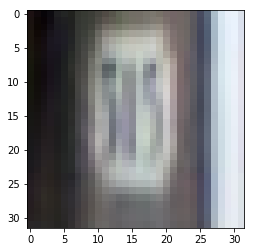

5.0


In [11]:
plot_img(train_images[21])
print(train_labels[21])